## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai.vision import *

In [3]:
import DAT259.setup as setup
import DAT259.wgan as wgan
import DAT259.superresgan as superres
import DAT259.segmentation as seg

### Create a new project directory

In [6]:
project_name = 'test'
path_new_project = Path('Projects/' + project_name)

setup.create_folder(Path('Projects'))
setup.create_folder(path_new_project)

### Create testset and available training data

In [7]:
path_mask = Path('data/ISIC2018_Task1_Training_GroundTruth')
path_img = Path('data/ISIC2018_Task1-2_Training_Input')

In [8]:
train, test = setup.split_train_test(path_img, path_mask, 500)

### Save testset and available training data

In [9]:
path_data = Path(str(path_new_project) + '/data')
setup.create_folder(path_data)

In [10]:
train.to_csv(str(path_data) + '/available_training_data.csv')
test.to_csv(str(path_data) + '/test_data.csv')

# Generate masks

### Directory for generated masks

In [11]:
path_gen = Path(str(path_new_project) + '/generator')
setup.create_folder(path_gen)

### Get available training data

In [12]:
available_training_data = pd.read_csv(Path(str(path_data) + '/available_training_data.csv'), index_col = 0)
available_training_data.head()

,Image,Mask
0,ISIC_0014423.jpg,ISIC_0014423_segmentation.png
1,ISIC_0000391.jpg,ISIC_0000391_segmentation.png
2,ISIC_0008785.jpg,ISIC_0008785_segmentation.png
3,ISIC_0010603.jpg,ISIC_0010603_segmentation.png
4,ISIC_0001181.jpg,ISIC_0001181_segmentation.png


### Get trainingset with num_training_data masks

In [13]:
num_training_data = 100
training_data = available_training_data.sample(num_training_data)
print (len(training_data))
training_data.head()

100


,Image,Mask
295,ISIC_0016005.jpg,ISIC_0016005_segmentation.png
1161,ISIC_0013782.jpg,ISIC_0013782_segmentation.png
10,ISIC_0013749.jpg,ISIC_0013749_segmentation.png
870,ISIC_0000167.jpg,ISIC_0000167_segmentation.png
667,ISIC_0000173.jpg,ISIC_0000173_segmentation.png


Save the dataframe with training data:

In [14]:
training_data.to_csv(str(path_data) + '/training_data_' + str(num_training_data) + '.csv')

### Generate masks

Get the training data from file:

In [15]:
training_data = pd.read_csv(Path(str(path_data) + '/training_data_' + str(num_training_data) + '.csv'), index_col = 0)
training_data.head()

,Image,Mask
295,ISIC_0016005.jpg,ISIC_0016005_segmentation.png
1161,ISIC_0013782.jpg,ISIC_0013782_segmentation.png
10,ISIC_0013749.jpg,ISIC_0013749_segmentation.png
870,ISIC_0000167.jpg,ISIC_0000167_segmentation.png
667,ISIC_0000173.jpg,ISIC_0000173_segmentation.png


Generate mask:

In [16]:
num_mask_to_gen = 100
path_gen_masks = Path(str(path_gen) + '/generated_masks_' + str(num_mask_to_gen))
wgan.generate_masks(training_data, num_mask_to_gen, path_mask, path_gen_masks, epochs=1, bs=50) 

In [17]:
wgan.image_cleaner(str(path_gen_masks))

## Pretraining

In [18]:
training_data = pd.read_csv(Path(str(path_data) + '/training_data_' + str(num_training_data) + '.csv'), index_col = 0)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,5.126234,1394.695435,118.751968,4.011929,8.883893,0.288401,335.567230,926.338989,0.853134,00:32


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,508.446350,4.533013,0.832543,0.352006,0.433715,0.120726,1.089419,1.593905,0.110700,00:24


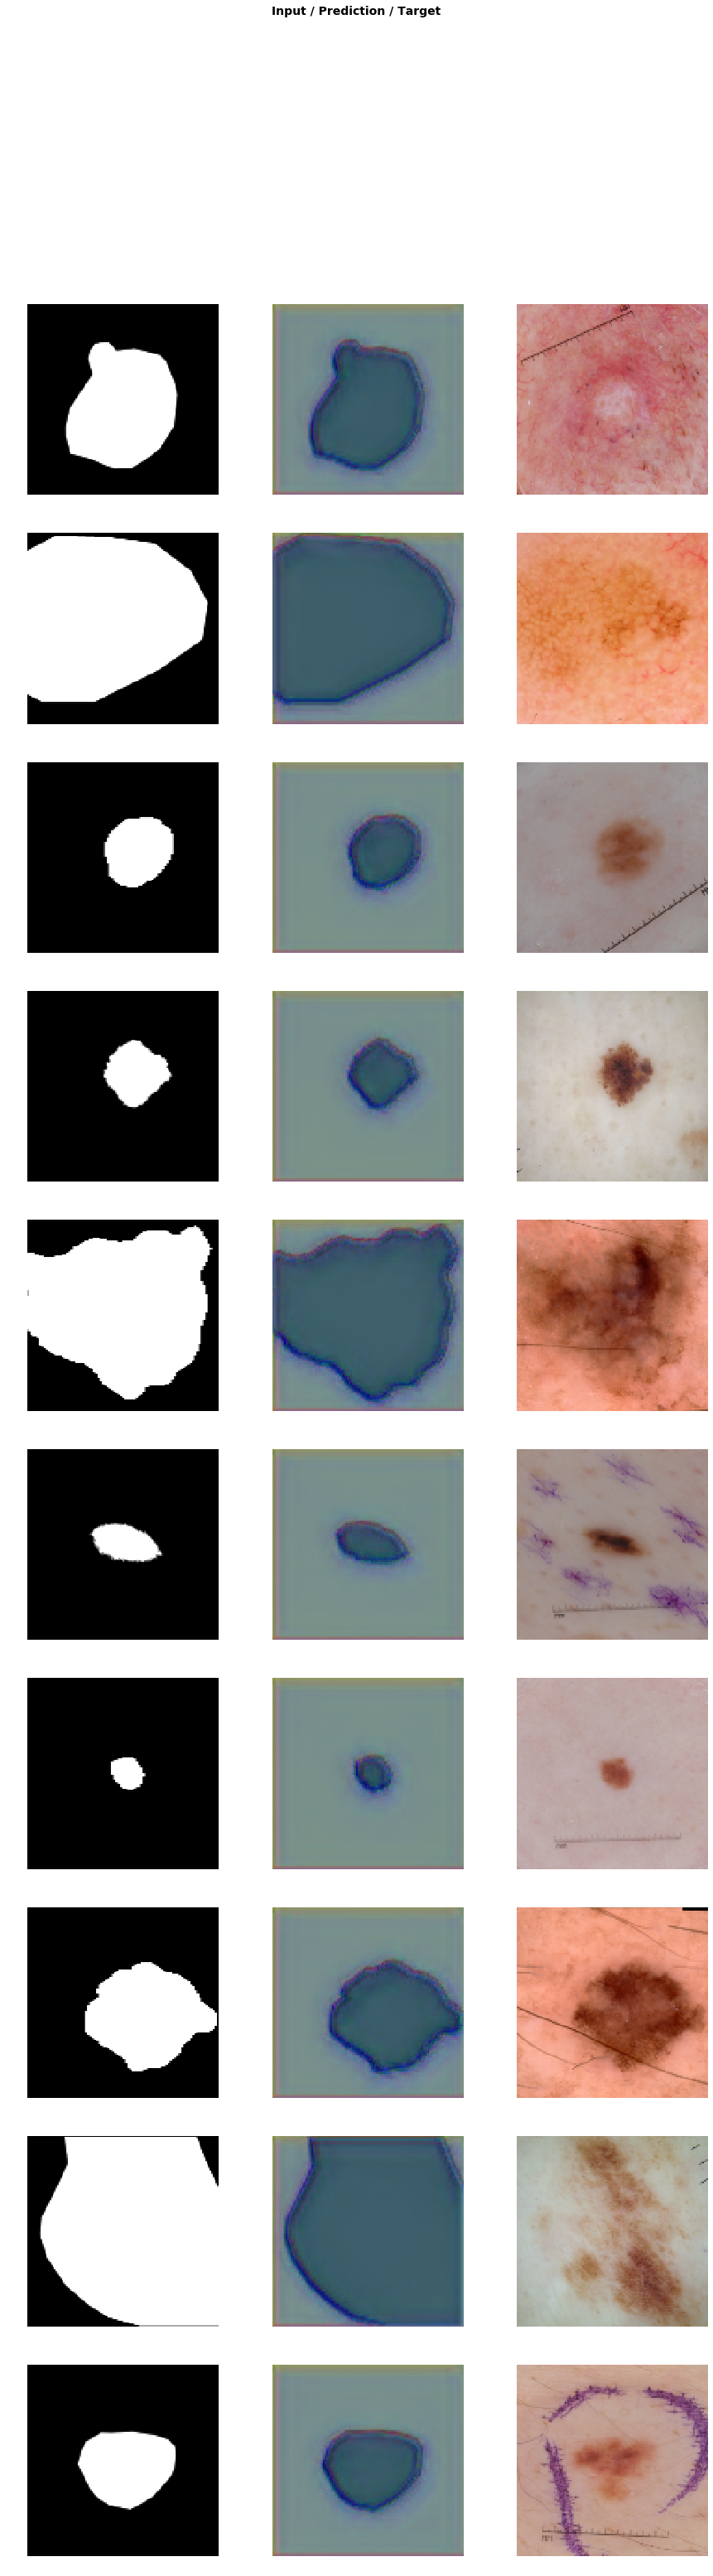

In [19]:
path_pretrained_masks = Path(str(path_gen) + '/pretrained_images_' + str(num_mask_to_gen))

learn = superres.train_generator(training_data, path_mask, path_img, path_pretrained_masks, num_epochs=1)

In [21]:
#loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())
superres.train_critic(100, Path('data'), path_gen, num_epochs=1)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.215642,0.003206,1.000000,00:21


## Train GAN

In [22]:
training_data = pd.read_csv(Path(str(path_data) + '/training_data_' + str(num_training_data) + '.csv'), index_col = 0)
training_data.head()

,Image,Mask
295,ISIC_0016005.jpg,ISIC_0016005_segmentation.png
1161,ISIC_0013782.jpg,ISIC_0013782_segmentation.png
10,ISIC_0013749.jpg,ISIC_0013749_segmentation.png
870,ISIC_0000167.jpg,ISIC_0000167_segmentation.png
667,ISIC_0000173.jpg,ISIC_0000173_segmentation.png


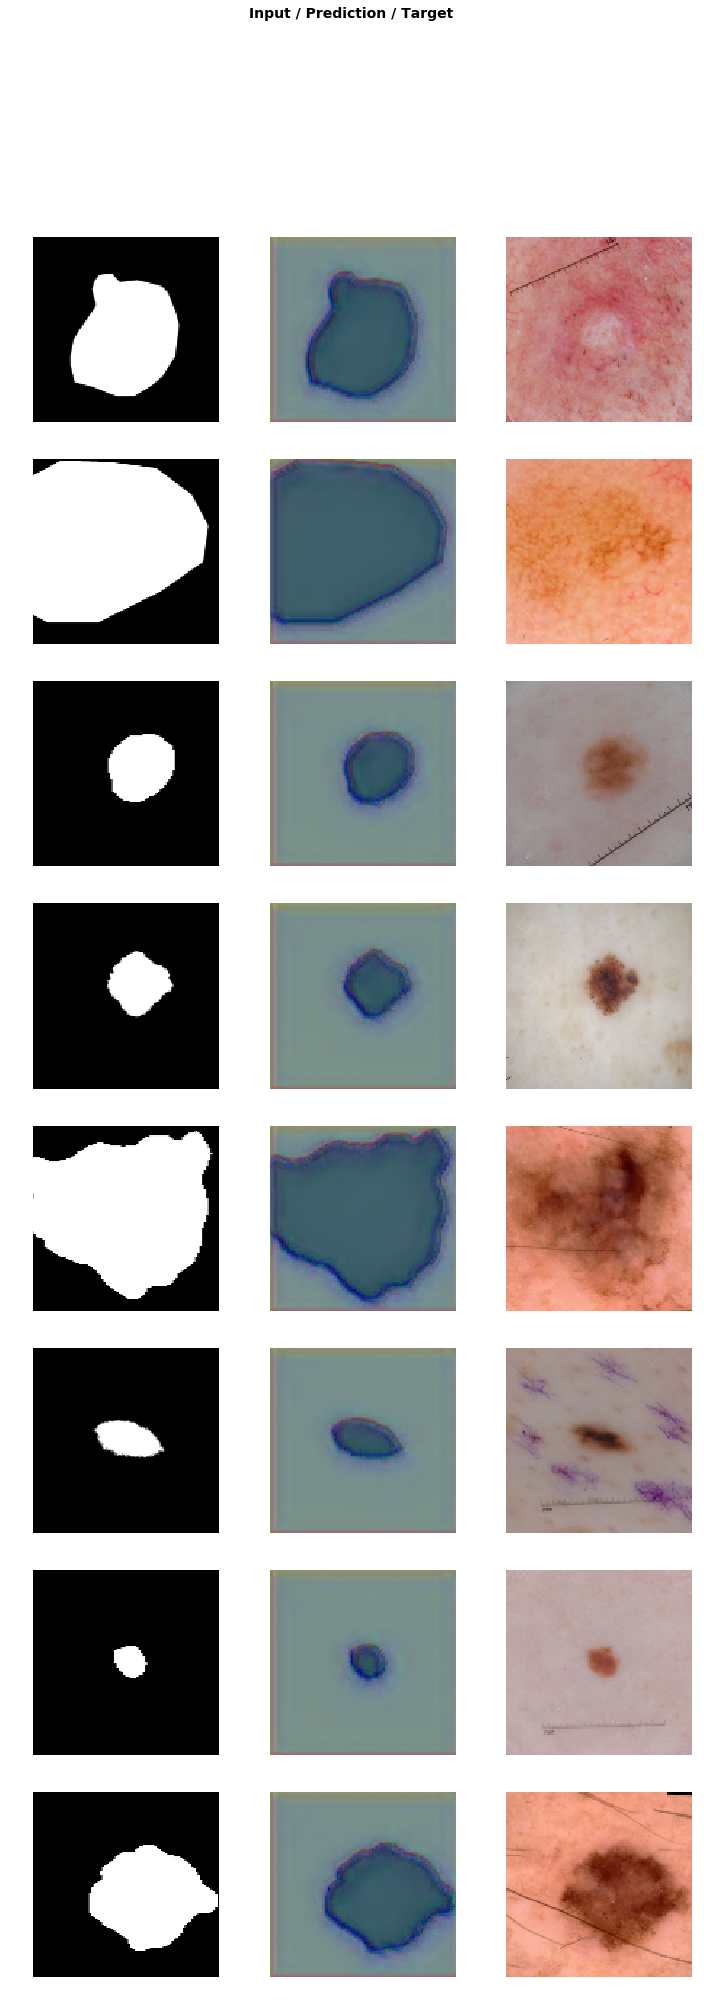

In [23]:
learn_generator = superres.train_gan(training_data, path_mask, path_img, num_epochs=1)

### Generate images

In [24]:
path_gen_images = str(path_gen) + '/generated_images_' + str(num_mask_to_gen)
setup.create_folder(path_gen_images)

In [25]:
superres.pred_gan(learn_generator, path_gen_masks, path_gen_images, num_mask_to_gen)

# Segmentation

### Resize testset

In [26]:
path_test = Path(str(path_new_project) + '/test')
setup.create_folder(path_test)

In [27]:
test_data = pd.read_csv(Path(str(path_data) + '/test_data.csv'), index_col = 0)

In [28]:
#images
img_size = 128
folder_name = 'test_img_' + str(img_size)
from_path = 'data/' + folder_name + '/'
to_path = Path(str(path_test) + '/' + folder_name)
test_img = test_data['Image']

seg.resize_img_folder(path_img, to_path, img_size, test_img)

In [29]:
#masks
img_size = 128
folder_name = 'test_mask_' + str(img_size)
from_path = 'data/' + folder_name + '/'
to_path = Path(str(path_test) + '/' + folder_name)
test_mask = test_data['Mask']

seg.resize_img_folder(path_mask, to_path, img_size, test_mask)

### Experiment1

In [30]:
num_org_data = [100]
num_gen_data = [100, 0]

In [31]:
training_data = pd.read_csv(Path(str(path_data) + '/training_data_' + str(num_training_data) + '.csv'), index_col = 0)

In [32]:
seg_path = Path(str(path_new_project) + '/segmentation')
setup.create_folder(seg_path)
pred_path = Path(str(path_new_project) + '/segmentation/predictions')
setup.create_folder(pred_path)
setup.create_folder(str(path_new_project) + '/models')

model_path = Path (str(path_new_project) + '/models/segmentation_models') 
setup.create_folder(model_path)

In [33]:
the_list = [100]

for i in num_org_data:
    num_of_org_data = str(i)
    setup.create_folder(str(model_path) + '/' + str(i))
    setup.create_folder(str(pred_path) + '/' + str(i))
    # loop for segmentation using different amount of generated data 
    #from_ISIC = setup.get_data(Path('data/csv/csv_' + num_of_org_data))
    training_data = pd.read_csv(Path(str(path_data) + '/training_data_' + str(i) + '.csv'), index_col = 0)
    gen_img_folder = 'generated_images_'+ num_of_org_data
    gen_mask_folder = 'generated_masks_' + num_of_org_data
    #test_list = [100, 0]

    for j in num_gen_data:

        # creating dataframes for the orginal dataset and the generated data
        #number_of_generated_data = test_list[i]
        #print(path_gen_images)
        df = seg.merge_df(path_data, Path(str(path_gen) + '/' + gen_img_folder), Path(str(path_gen) + '/' + gen_mask_folder), training_data, j)
        #print(df)
        # creating data for model training
        data = seg.data_mix("", df)
        
        #create learner
        learner = seg.create_learner(data)

        #Training and saving the segmentation model
        model_name = 'seg_'+ str(i)+ '_' + str(j)
        #setup.create_folder(str(path_new_project) + 'models')
        #if (os.path.isdir('data/models/segmentation_models')==False): os.mkdir('data/models/segmentation_models')
        
        #if (os.path.isdir('data/models/segmentation_models/' + num_of_org_data)==False): os.mkdir('data/models/segmentation_models/' + num_of_org_data)
        #Se på dette!
        #if (os.path.isdir('data/predictions')==False): os.mkdir('data/predictions')
        #if (os.path.isdir('data/predictions/' + num_of_org_data)==False): os.mkdir('data/predictions/' + num_of_org_data)
        full_model_path = Path('../' + str(model_path) + '/' + str(i) + '/' + model_name)
        #print (full_model_path)
        #if (os.path.isdir(full_model_path)==False): os.mkdir(full_model_path)
        seg.seg_model(learner, full_model_path)
#gradient y=ax+b
        # prediction and saving them 
        save_pred_at = str(pred_path) + '/' + str(i) + '/' + str(j) + '/'
        if (os.path.isdir(save_pred_at)==False): os.mkdir(save_pred_at)
        seg.predict_on_test_data(learner, save_pred_at)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.355575,0.209453,0.515312,00:11


epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.242877,0.169584,0.482663,00:10


epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.807999,0.485528,0.515286,00:13


epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.402588,0.400268,0.535901,00:14


In [34]:
df10 = pd.DataFrame(columns = num_gen_data, index = num_org_data);
for i in num_org_data:
    for j in num_gen_data:
        df10[j][i] = seg.dice_score(str(pred_path)+ '/' + str(i)+ '/' + str(j), str(to_path));

In [35]:
df10

,100,0
100,0.307194,0.279051


In [36]:
import datetime
date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

result_path = Path(str(seg_path) + '/results')
setup.create_folder(result_path)
#if (os.path.isdir('data/results')==False): os.mkdir('data/results')
df10.to_csv(str(result_path) + '/' + str(date))

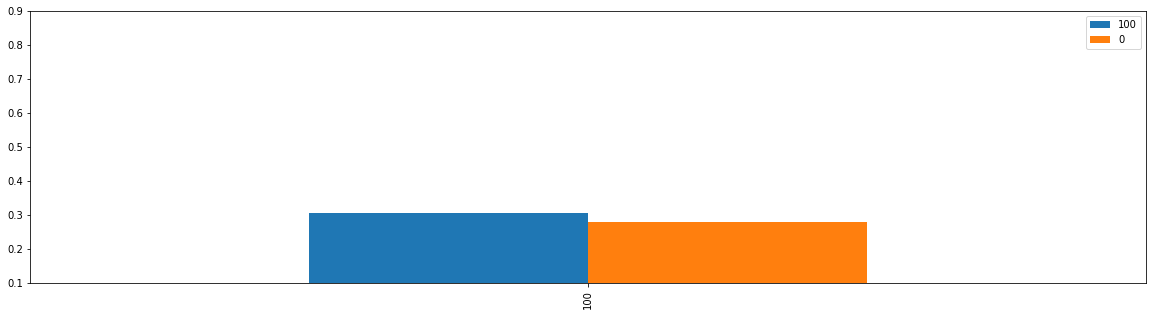

In [37]:
df10.plot(kind='bar', figsize = (20,5), ylim=(0.1,0.9))